In [ ]:
import numpy as np
from scipy.io import loacadmat
from scipy.optimize import minimize

In [ ]:
def preprocess():
    """
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.
z
     Output:
     train_data: matrix of training set. Each row of train_data contains
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the
       training set
     test_data: matrix of training set. Each row of test_data contains
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


In [4]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    train_data = np.hstack((np.ones((n_data, 1)), train_data))

    # Reshape initialWeights
    initialWeights = initialWeights.reshape(-1, 1)

    # Sigmoid function
    theta = sigmoid(np.dot(train_data, initialWeights))

    # Error function
    error = -np.mean(labeli * np.log(theta) + (1 - labeli) * np.log(1 - theta))

    # Gradient calculation
    error_grad = np.dot(train_data.T, (theta - labeli)) / n_data

    return error, error_grad.flatten()


    return error, error_grad


In [5]:
def blrPredict(W, data):
    n_data = data.shape[0]

    # Add bias to data
    data = np.hstack((np.ones((n_data, 1)), data))

    # Compute probabilities
    probabilities = sigmoid(np.dot(data, W))

    # Find the class with maximum probability
    label = np.argmax(probabilities, axis=1).reshape(-1, 1)

    return label


In [6]:
def mlrObjFunction(params, *args):
    train_data, labeli = args

    # Add bias to train_data
    n_data = train_data.shape[0]
    train_data = np.hstack((np.ones((n_data, 1)), train_data))

    # Reshape parameters
    params = params.reshape((train_data.shape[1], -1))

    # Softmax function
    theta = np.exp(np.dot(train_data, params))
    theta /= np.sum(theta, axis=1, keepdims=True)

    # Error function
    error = -np.sum(labeli * np.log(theta)) / n_data

    # Gradient calculation
    error_grad = np.dot(train_data.T, (theta - labeli)) / n_data

    return error, error_grad.flatten()


In [7]:
def mlrPredict(W, data):
    n_data = data.shape[0]

    # Add bias to data
    data = np.hstack((np.ones((n_data, 1)), data))

    # Compute probabilities
    probabilities = np.exp(np.dot(data, W))
    probabilities /= np.sum(probabilities, axis=1, keepdims=True)

    # Find the class with maximum probability
    label = np.argmax(probabilities, axis=1).reshape(-1, 1)

    return label


In [8]:
# Logistic Regression Script
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# Number of classes
n_class = 10

# Number of training samples and features
n_train = train_data.shape[0]
n_feature = train_data.shape[1]

# Prepare label matrix for one-vs-all classification
Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1)).flatten()
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

# Find the accuracy on Training Dataset
predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')






 Training set Accuracy:92.664%

 Validation set Accuracy:91.52%

 Testing set Accuracy:91.99000000000001%


SVM with Linear Kernel:
Training Accuracy: 97.286 %
Validation Accuracy: 93.64 %
Testing Accuracy: 93.78 %

SVM with RBF Kernel (gamma=1):
Training Accuracy: 100.0 %
Validation Accuracy: 15.479999999999999 %
Testing Accuracy: 17.14 %

SVM with RBF Kernel (default gamma):
Training Accuracy: 98.982 %
Validation Accuracy: 97.89 %
Testing Accuracy: 97.87 %


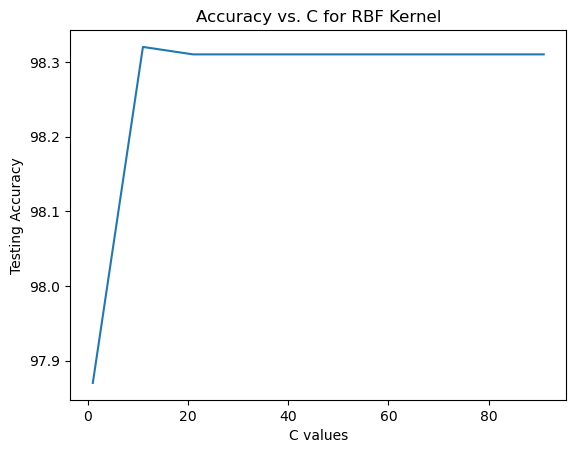

C:\Users\SHAIK AREEF\AppData\Local\Temp\ipykernel_13096\596699325.py:49: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)



 Training set Accuracy:93.448%

 Validation set Accuracy:92.47999999999999%


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

In [9]:
from sklearn.svm import SVC

# Linear Kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(train_data, train_label.ravel())
print('SVM with Linear Kernel:')
print('Training Accuracy:', svm_linear.score(train_data, train_label) * 100, '%')
print('Validation Accuracy:', svm_linear.score(validation_data, validation_label) * 100, '%')
print('Testing Accuracy:', svm_linear.score(test_data, test_label) * 100, '%')

# RBF Kernel (gamma=1)
svm_rbf_1 = SVC(kernel='rbf', gamma=1)
svm_rbf_1.fit(train_data, train_label.ravel())
print('\nSVM with RBF Kernel (gamma=1):')
print('Training Accuracy:', svm_rbf_1.score(train_data, train_label) * 100, '%')
print('Validation Accuracy:', svm_rbf_1.score(validation_data, validation_label) * 100, '%')
print('Testing Accuracy:', svm_rbf_1.score(test_data, test_label) * 100, '%')

# RBF Kernel (default gamma)
svm_rbf_default = SVC(kernel='rbf')
svm_rbf_default.fit(train_data, train_label.ravel())
print('\nSVM with RBF Kernel (default gamma):')
print('Training Accuracy:', svm_rbf_default.score(train_data, train_label) * 100, '%')
print('Validation Accuracy:', svm_rbf_default.score(validation_data, validation_label) * 100, '%')
print('Testing Accuracy:', svm_rbf_default.score(test_data, test_label) * 100, '%')

# Varying C values
C_values = list(range(1, 101, 10))
accuracy_test = []
for C in C_values:
    svm_rbf_c = SVC(kernel='rbf', C=C)
    svm_rbf_c.fit(train_data, train_label.ravel())
    accuracy_test.append(svm_rbf_c.score(test_data, test_label) * 100)

# Plot Accuracy vs. C
import matplotlib.pyplot as plt
plt.plot(C_values, accuracy_test)
plt.xlabel('C values')
plt.ylabel('Testing Accuracy')
plt.title('Accuracy vs. C for RBF Kernel')
plt.show()

# Extra Credit: Multi-Class Logistic Regression Script
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label).astype(float)) + '%'))
